# Delfland

### Create shortest_path RHWS network

Code is based on: https://github.com/Deltares/Ribasim-NL/blob/1ad35931f49280fe223cbd9409e321953932a3a4/notebooks/ijsselmeermodel/netwerk.py#L55


In [16]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import fiona
import tqdm.auto as tqdm

import shapely
from shapely.geometry import LineString, Point,MultiPoint,MultiLineString,Polygon
from shapely.ops import split, nearest_points
from shapely.wkt import dumps
import geopandas as gpd
import numpy as np

### Load Data

In [17]:
waterschap = "Delfland"

# Define crossings file path
path2json = "/DATAFOLDER/projects/4750_30/Scripts/Ribasim-NL/src/peilbeheerst_model/waterschappen.json"
data_path_str = pd.read_json(path2json).loc['init'][waterschap]['output_path']
data_path = f"/DATAFOLDER/projects/4750_30/{data_path_str.split('../')[-1]}"

# Load crossings file
DATA = {L: gpd.read_file(data_path, layer=L) for L in fiona.listlayers(data_path)}

### Select rhws

In [18]:
# Select RHWS peilgebeied & calculate representative point
gdf_rhws = DATA["peilgebied"].loc[DATA["peilgebied"]["peilgebied_cat"] == 1].copy()
gdf_rhws["representative_point"] = gdf_rhws.representative_point()

# Apply aggregation level based filter
gdf_cross = DATA["crossings_hydroobject_filtered"].loc[DATA["crossings_hydroobject_filtered"]["agg_links_in_use"]].copy() # filter aggregation level

### Define functions
1. splitting functions
2. connect graphs functions
3. explode nodes functions

In [19]:
def split_line_at_point(line, point):
    buff = point.buffer(1e-4)  # Small buffer around the point
    split_result = split(line, buff)
    if len(split_result.geoms) in [2, 3]:
        # Assume first and last segments are the result, ignore tiny middle segment if exists
        result = MultiLineString([split_result.geoms[0], split_result.geoms[-1]])
    else:
        # Return the original line as a MultiLineString for consistency if no split occurred
        result = MultiLineString([line])
    return result

def split_lines_at_intersections(gdf_object):
    split_lines = []
    attributes = gdf_object.drop(columns=['geometry'])  # Preserve non-geometry attributes

    for idx, row in gdf_object.iterrows():
        was_split = False

        # Get potential intersections using spatial index
        possible_matches_index = list(gdf_object.sindex.intersection(row.geometry.bounds))
        possible_matches = gdf_object.iloc[possible_matches_index].drop(idx)  # Exclude self
        precise_matches = possible_matches[possible_matches.intersects(row.geometry)]
        
        for match_idx, match in precise_matches.iterrows():
            if row.geometry.intersects(match.geometry):
                intersection = row.geometry.intersection(match.geometry)
                if isinstance(intersection, Point):
                    # Split the current line at the intersection point
                    try:
                        split_result = split_line_at_point(row.geometry, intersection)
                        for geom in split_result.geoms:
                            new_row = row.copy()
                            new_row.geometry = geom
                            split_lines.append(new_row)
                        was_split = True
                    except ValueError as e:
                        print(f"Error splitting line: {e}")
                # Add other intersection types handling if needed
                break  # Assumes only one split per line; remove or modify for multiple splits

        if not was_split:
            # If the line was not split, include the original line
            split_lines.append(row)

    # Create a new GeoDataFrame from the split or original lines
    result_gdf = gpd.GeoDataFrame(split_lines, columns=gdf_object.columns)
    return result_gdf

def component_to_gdf(component, node_geometries):
    geometries = [node_geometries[node] for node in component]
    return gpd.GeoDataFrame(geometry=geometries, index=list(component))

def connect_components(graph, node1, node2, node_geometries):
    geom1 = node_geometries[node1]
    geom2 = node_geometries[node2]
    new_edge_geom = LineString([geom1.coords[0], geom2.coords[0]])
    graph.add_edge(node1, node2, geometry=new_edge_geom)
    
def find_closest_component_pair(largest_gdf, smaller_gdfs):
    print(len(smaller_gdfs), end='\r')
    sgdf = gpd.GeoSeries([shapely.geometry.MultiPoint(small_gdf.geometry.tolist()) for small_gdf in smaller_gdfs])
    nearest_i, dist2 = sgdf.sindex.nearest(largest_gdf.geometry, return_all=False, return_distance=True)
    li, si = nearest_i[:, np.argmin(dist2)]
    
    nearest_idx, dist = smaller_gdfs[si].sindex.nearest(largest_gdf.geometry.iat[li], return_all=False, return_distance=True)
    node_in_smaller = smaller_gdfs[si].index[nearest_idx[1,0]]
    node_in_largest = largest_gdf.index[li]
    closest_pair_nodes = (node_in_largest, node_in_smaller)
    # print("done") 
    return si, closest_pair_nodes


def cut_linestring_at_interval(line, interval):
    """Cut a LineString into segments of a specified interval."""
    # Calculate the number of segments needed
    num_segments = int(np.ceil(line.length / interval))
    if num_segments == 1:
        return [line]

    points = [line.interpolate(distance) for distance in np.linspace(0, line.length, num_segments + 1)]
    return [LineString([points[i], points[i+1]]) for i in range(num_segments)]

def explode_linestrings(gdf, interval):
    """Explode LineStrings in a GeoDataFrame into smaller segments based on a distance interval."""
    segments = []
    for _, row in gdf.iterrows():
        line = row.geometry
        segments.extend(cut_linestring_at_interval(line, interval))

    return gpd.GeoDataFrame(geometry=segments, crs=gdf.crs)


def connect_linestrings_within_distance(gdf, max_distance=4):

        gdf = gdf.explode(ignore_index=False, index_parts=True)
        gdf["geometry"] = gdf.make_valid()
        gdf["geometry"] = gdf.geometry.apply(shapely.force_2d)
        gdf = gdf[~gdf.is_empty].copy()

        change_idx, change_geom = [], []
        for row in tqdm.tqdm(
            gdf.itertuples(),
            total=len(gdf),
        ):
            ps = row.geometry.boundary.geoms
            if len(ps) != 2:
                continue
            p0, p1 = ps

            p0_changed, p1_changed = False, False
            idx0 = gdf.sindex.query(p0.buffer(max_distance), predicate="intersects")
            if len(idx0) > 0:
                dist0 = gdf.iloc[idx0].distance(p0)
                if (dist0 > 10E-8).any():
                    snap_lbl0 = dist0[dist0 > 10E-8].idxmin()
                    geom = gdf.geometry.at[snap_lbl0]
                    p0 = geom.interpolate(geom.project(p0))
                    p0_changed = True

            idx1 = gdf.sindex.query(p1.buffer(max_distance), predicate="intersects")
            if len(idx1) > 0:
                dist1 = gdf.iloc[idx1].distance(p1)
                if (dist1 > 10E-8).any():
                    snap_lbl1 = dist1[dist1 > 10E-8].idxmin()
                    geom = gdf.geometry.at[snap_lbl1]
                    p1 = geom.interpolate(geom.project(p1))
                    p1_changed = True

            if p0_changed or p1_changed:
                coords = list(row.geometry.coords)
                if p0_changed:
                    coords = list(p0.coords) + coords
                if p1_changed:
                    coords = coords + list(p1.coords)
                change_idx.append(row.Index)
                change_geom.append(LineString(coords))

        if len(change_idx) > 0:
            gdf.loc[change_idx, "geometry"] = change_geom

        return gdf

# Shortest Path

  0%|          | 0/54 [00:00<?, ?it/s]

0
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/43 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
1
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/25 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
2
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/1 [00:00<?, ?it/s]

Create NetworkX
index 0 is out of bounds for axis 1 with size 0
3
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/7 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
4
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/2 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
5
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/38 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
6
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/70 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
7
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/56 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
8
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/7 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
9
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/32 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
10
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/10 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
11
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/8 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
12
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/2 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
13
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/8 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
14
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/5 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
15
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/4 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
16
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/17 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
17
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/7 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
18
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/10 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
19
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/30 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
20
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/11 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
21
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/13 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output


/tmp/ipykernel_867620/2271453216.py:187: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8,8))


Writing Output
22
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/4 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
23
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/14 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
24
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/5 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
25
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


0it [00:00, ?it/s]

Create NetworkX
index 0 is out of bounds for axis 1 with size 0
26
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/7 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
27
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/25 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
28
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/21 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
29
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/11 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
30
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/11 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
31
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/4 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
32
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/91 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
33
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/3 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
34
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/117 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
35
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/29 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
36
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/4 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
37
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/18 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
38
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/8 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
39
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/38 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
40
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/16 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
41
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/39 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
42
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/2231 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
43
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/65 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
44
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/4 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
45
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/1 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
46
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/2272 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
47
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/2 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
48
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/2293 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
49
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/1039 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
50
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


0it [00:00, ?it/s]

Create NetworkX
index 0 is out of bounds for axis 1 with size 0
51
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/1 [00:00<?, ?it/s]

Create NetworkX
index 0 is out of bounds for axis 1 with size 0
52
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/9554 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output
53
Select Crossings/Hydroobjects
Clip Crossings/Hydroobjects
Split Hydroobjects at Intersect
Connect Hydroobjects within distance


  0%|          | 0/1205 [00:00<?, ?it/s]

Create NetworkX
Find distruptions in Graph
Plotting Output
Writing Output


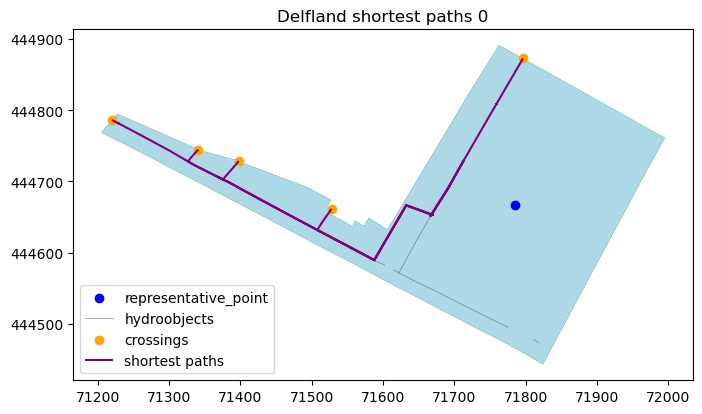

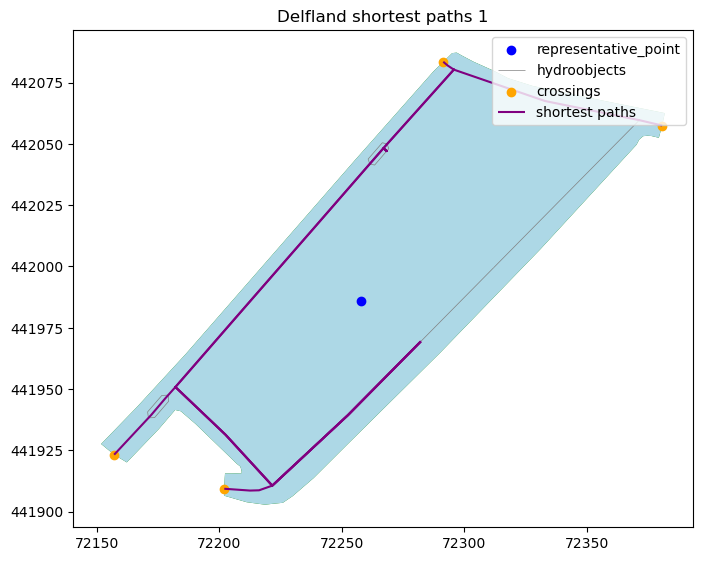

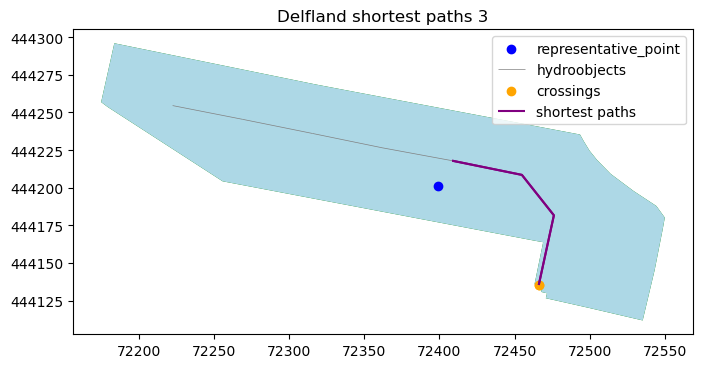

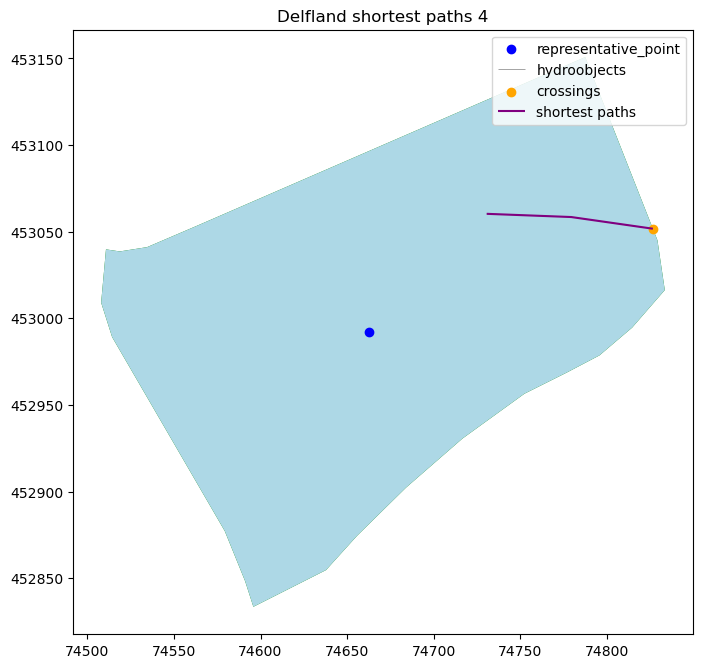

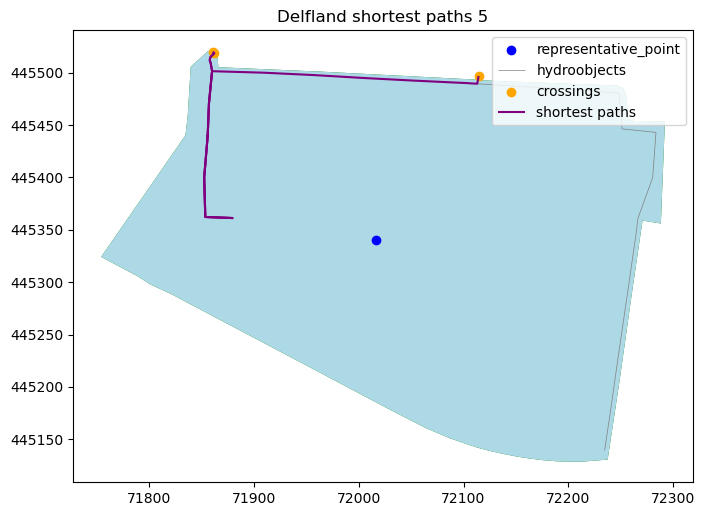

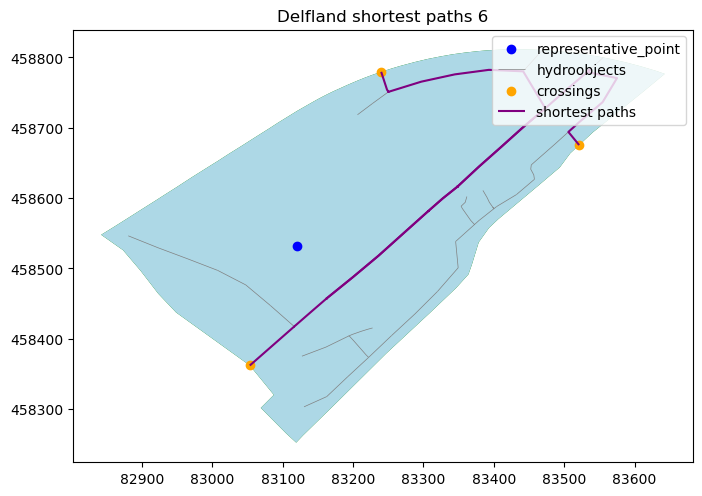

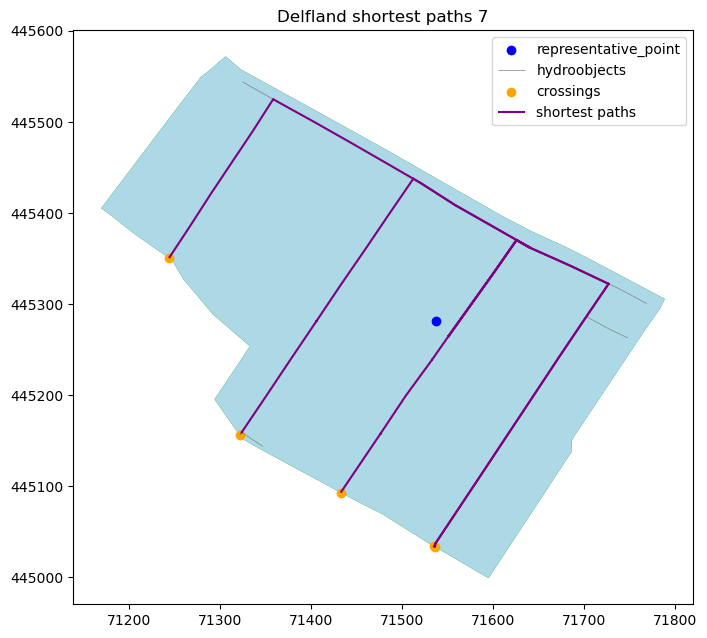

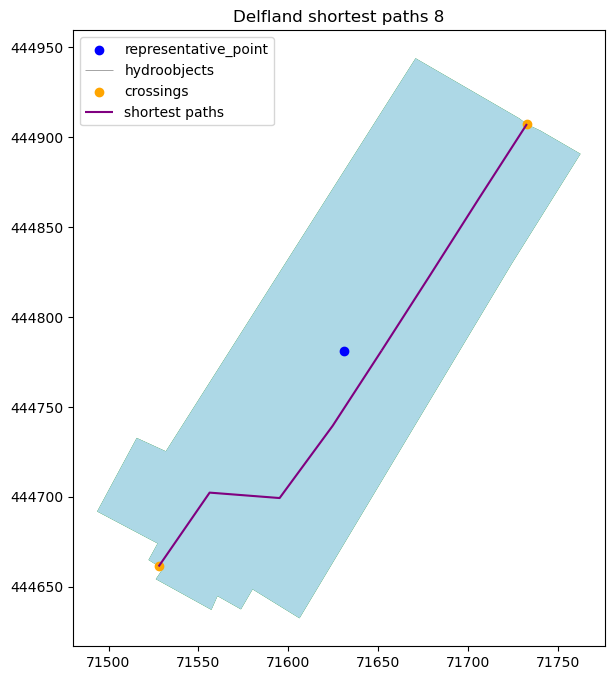

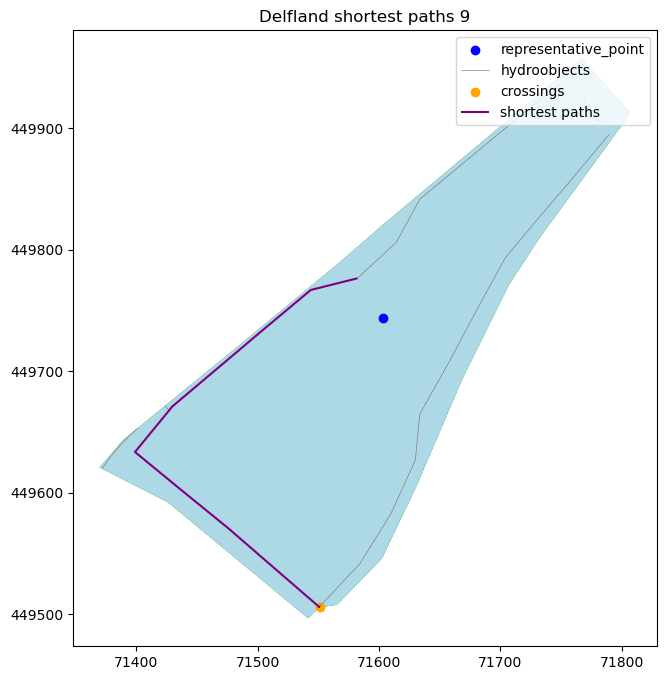

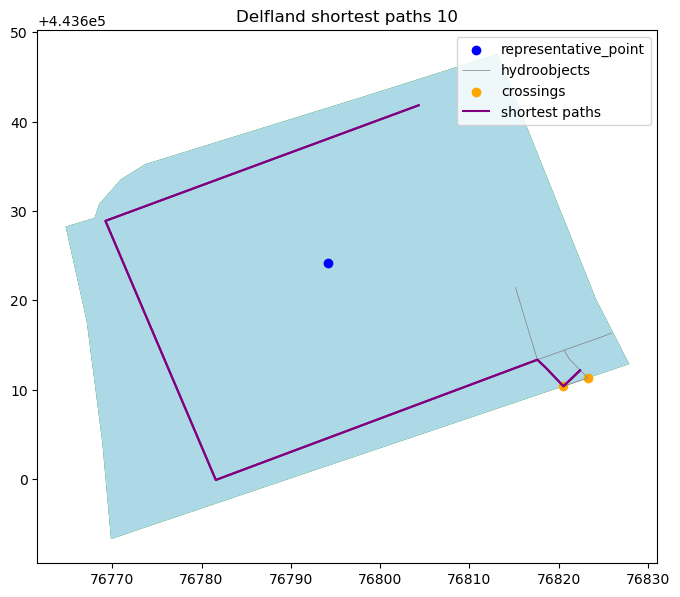

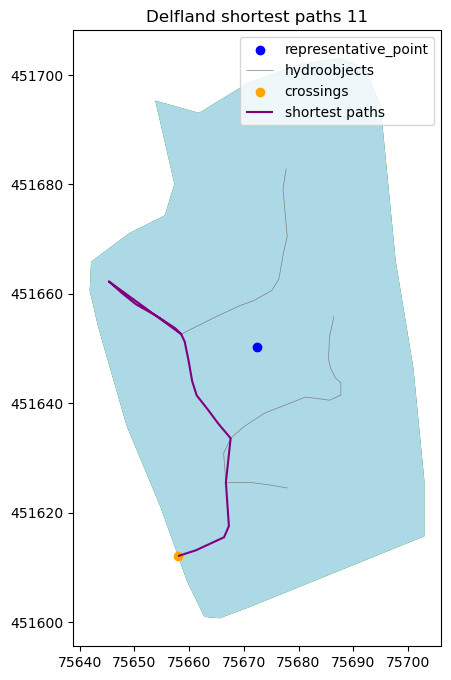

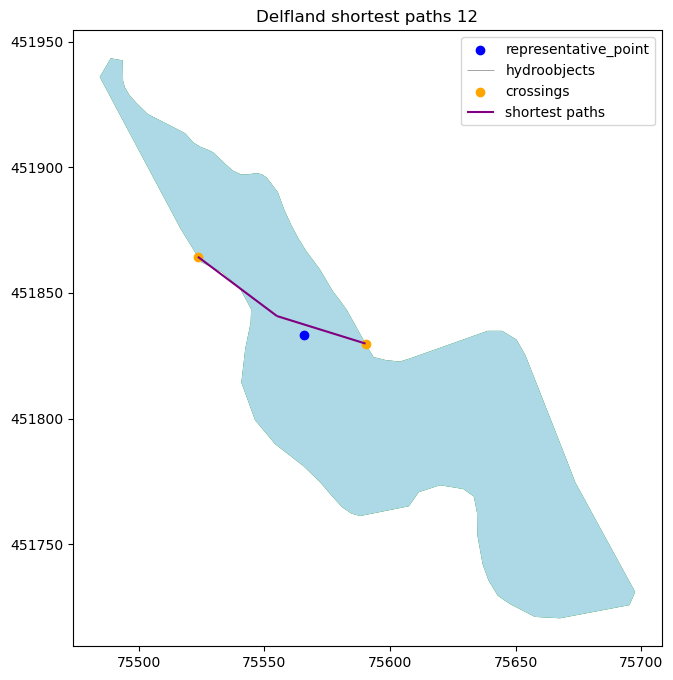

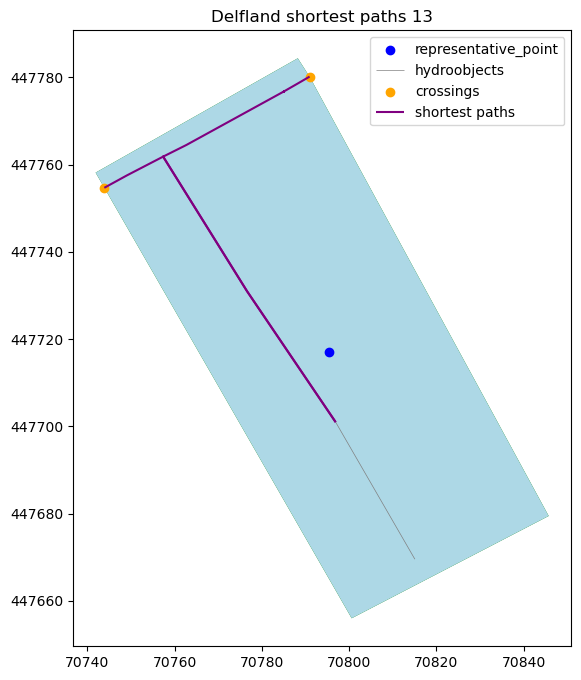

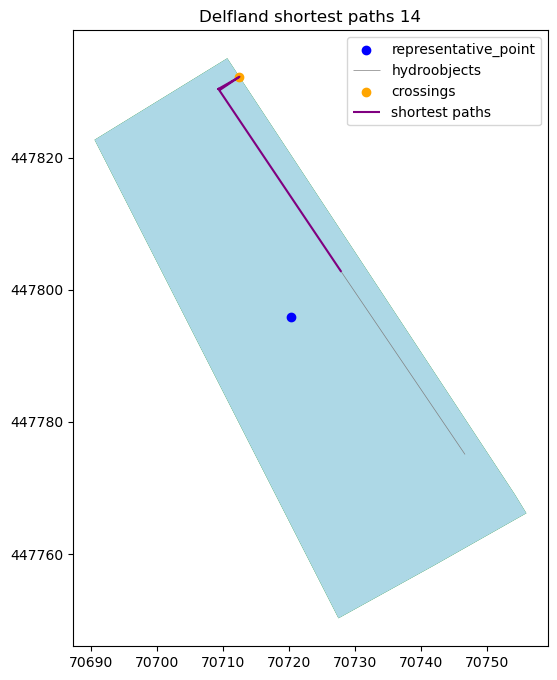

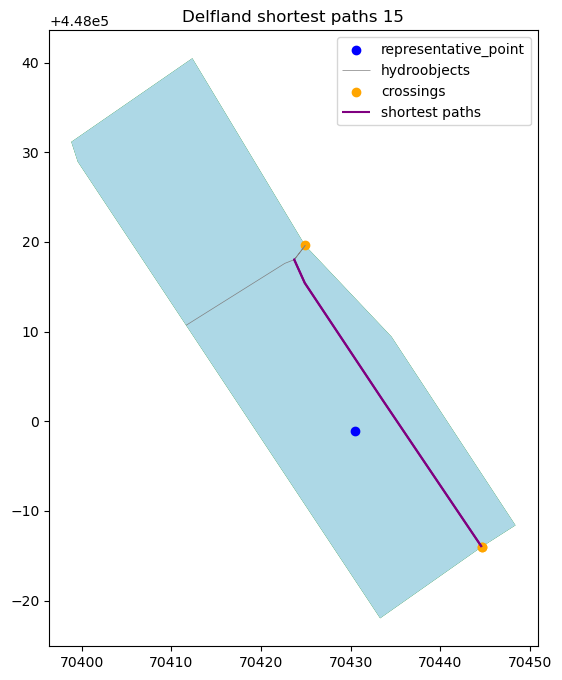

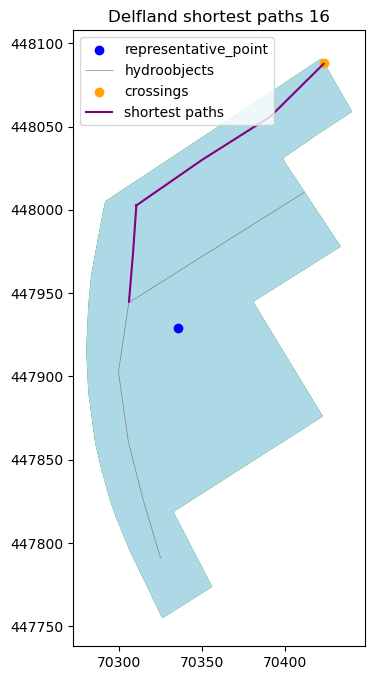

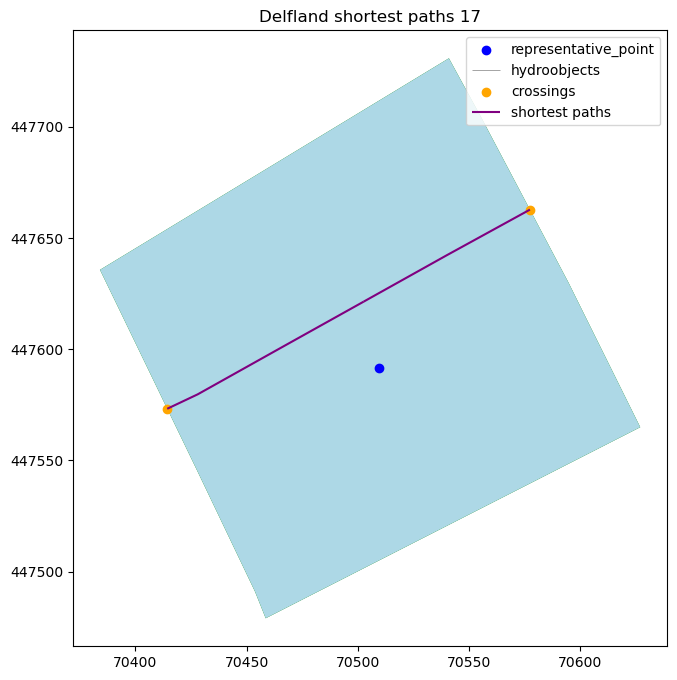

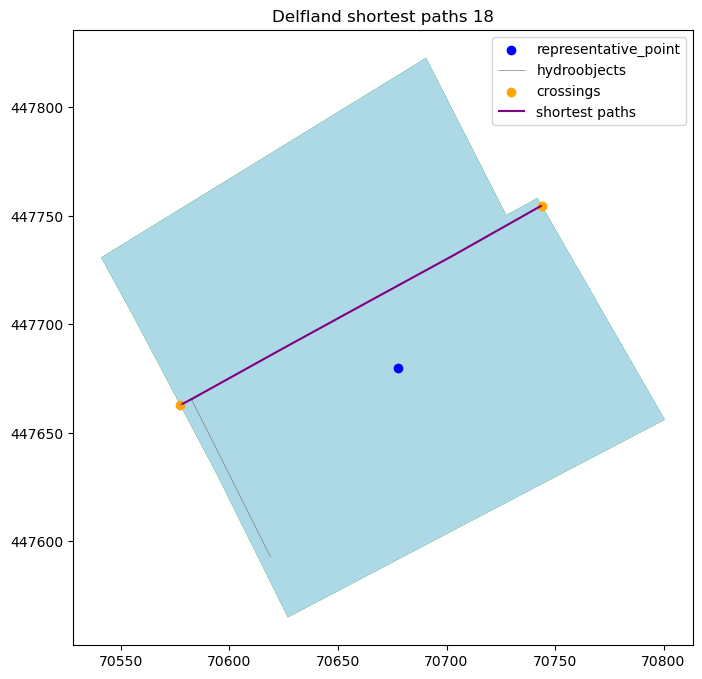

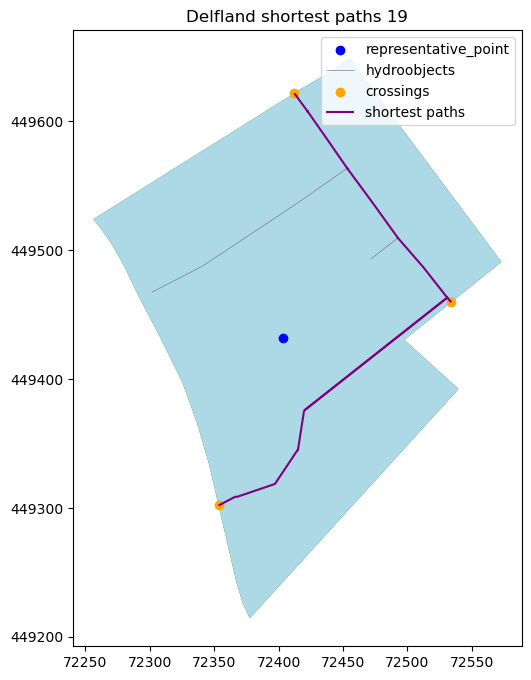

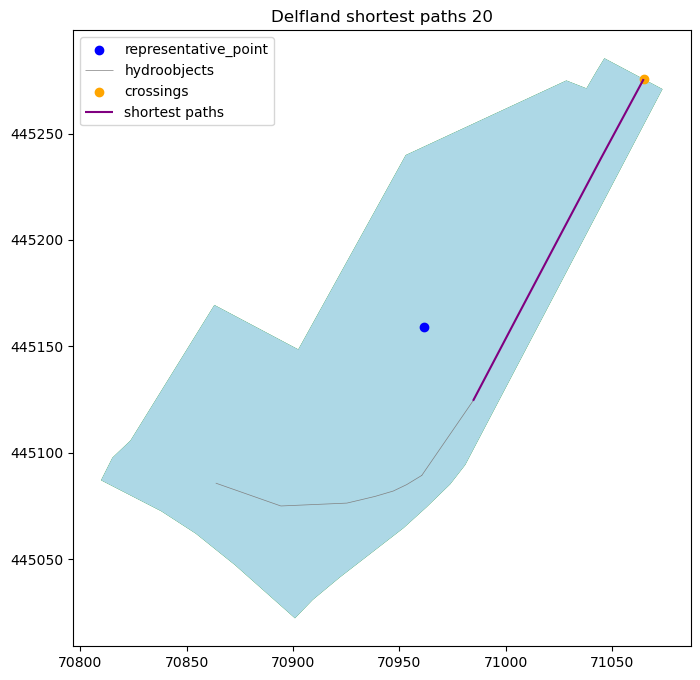

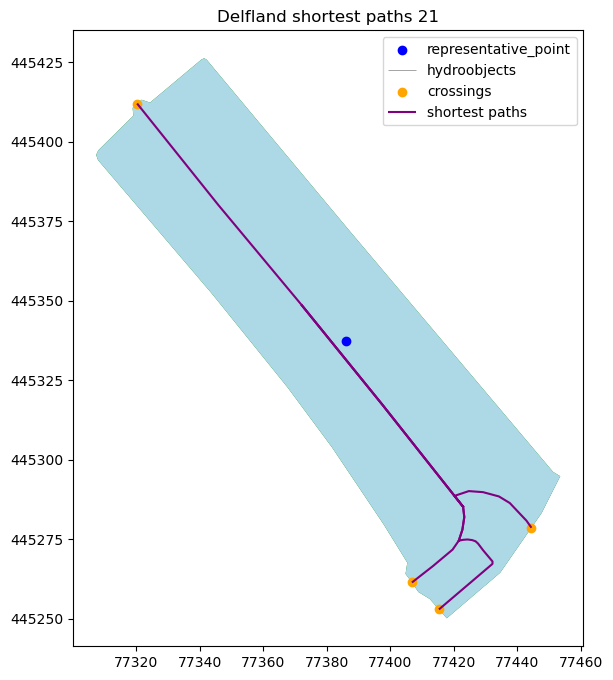

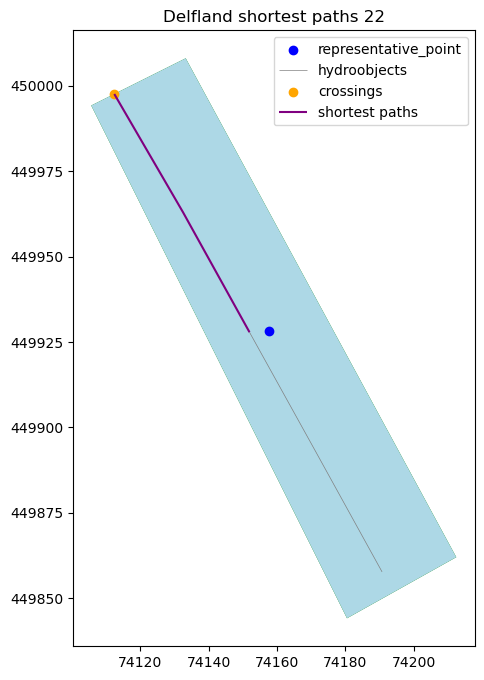

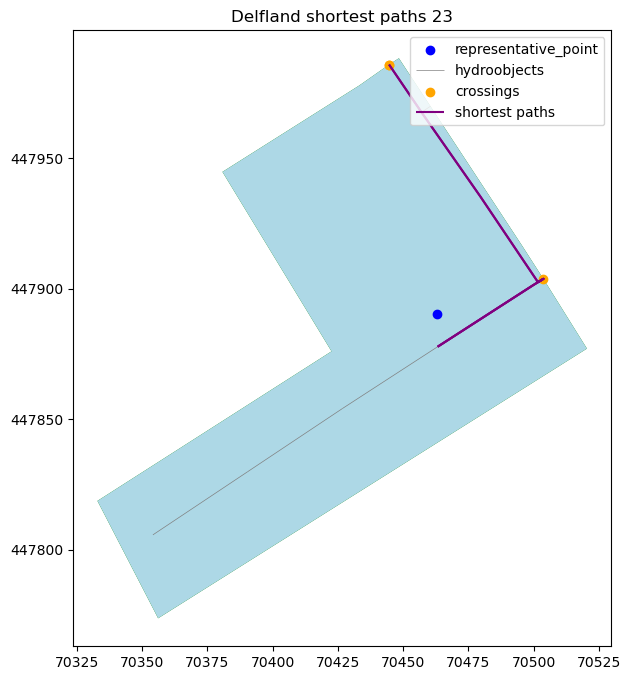

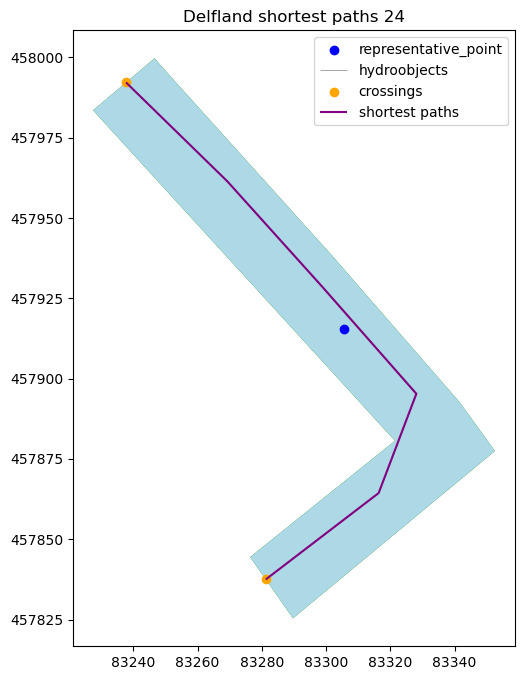

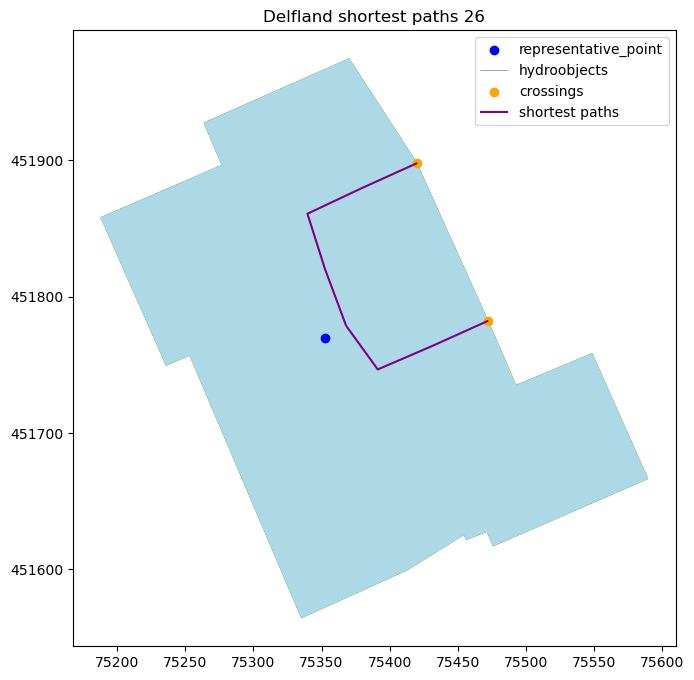

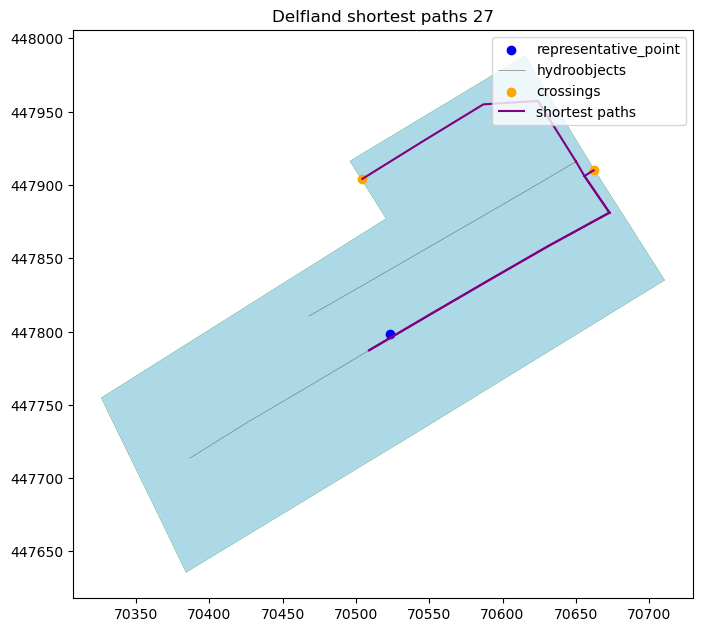

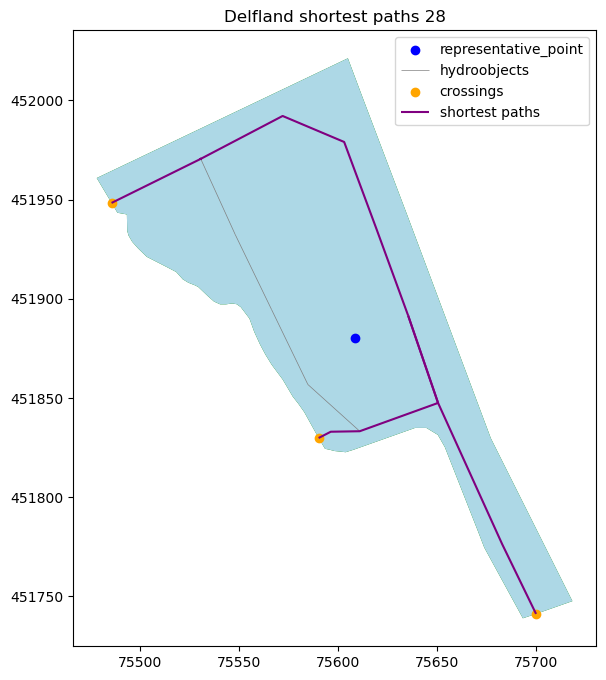

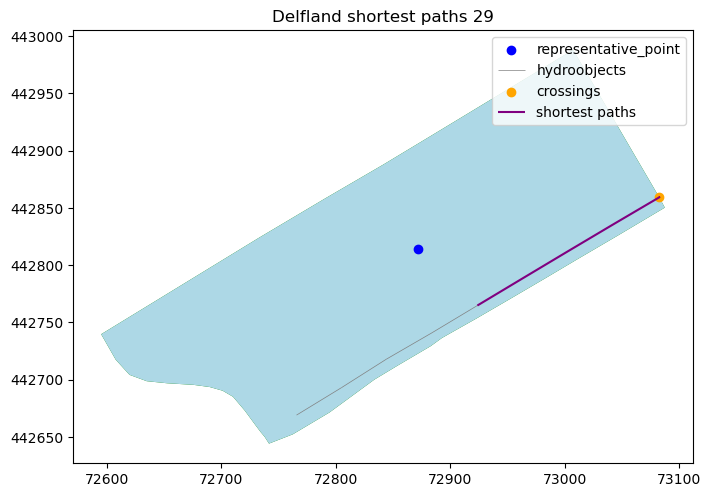

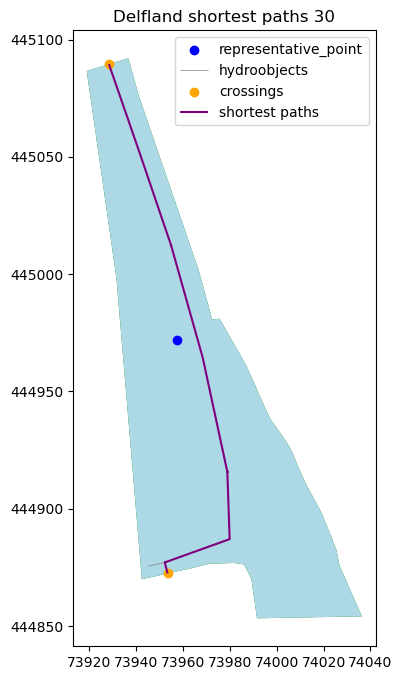

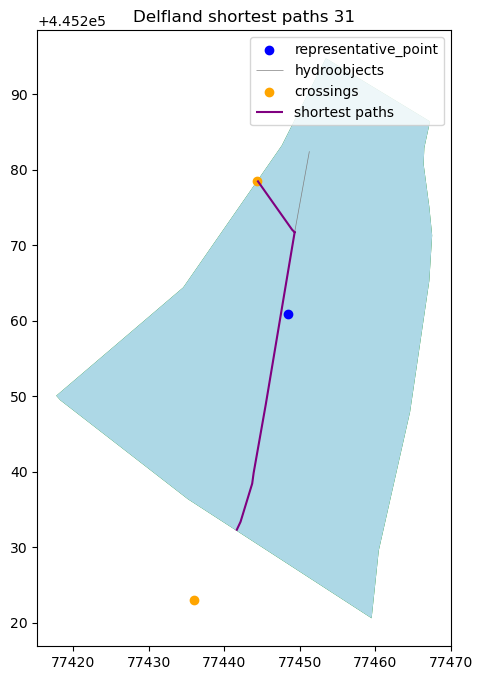

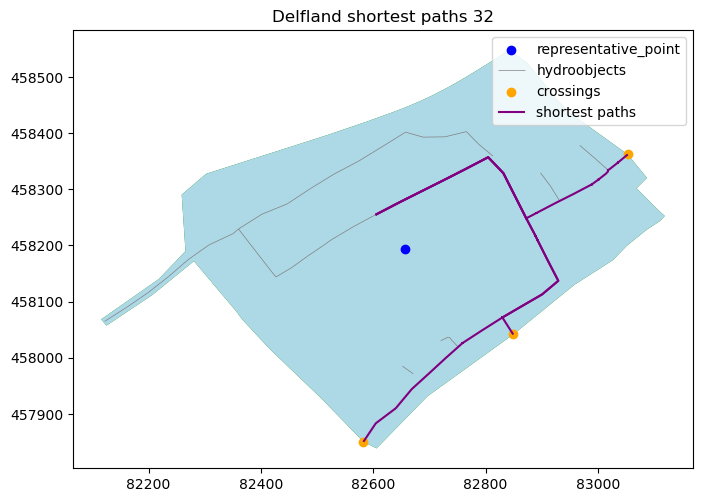

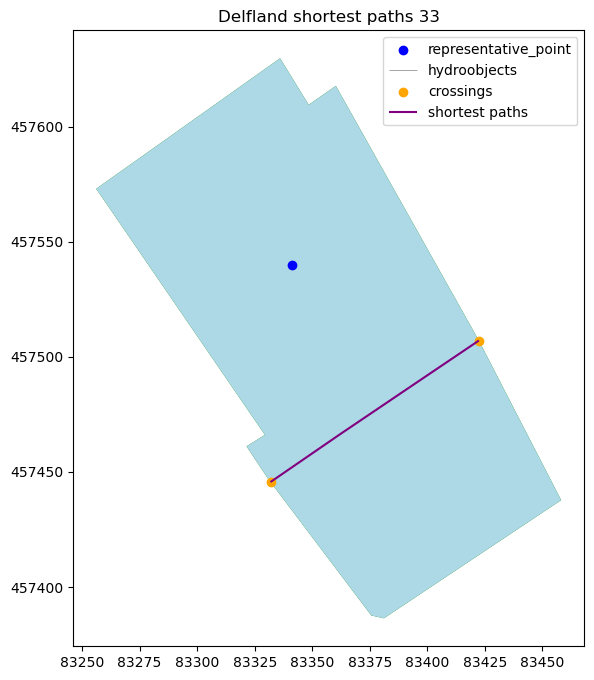

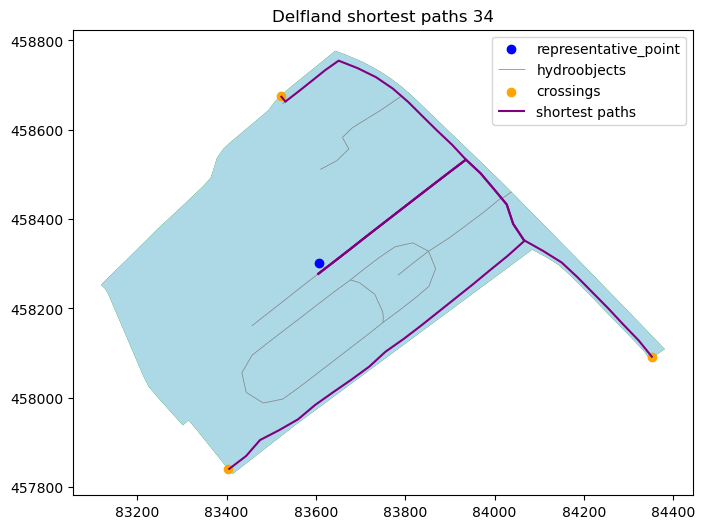

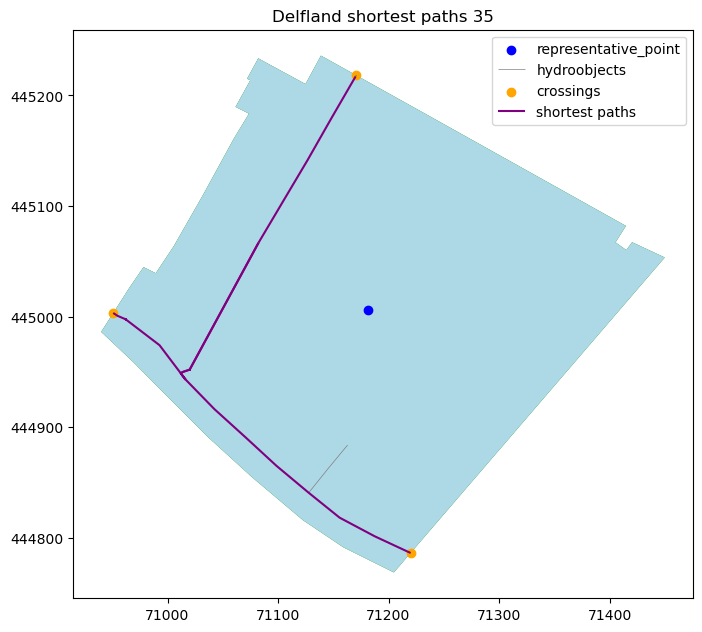

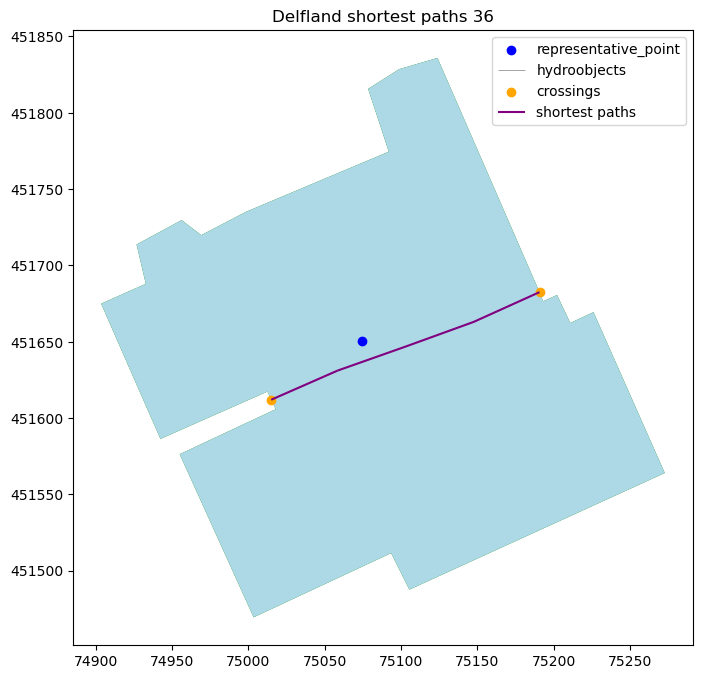

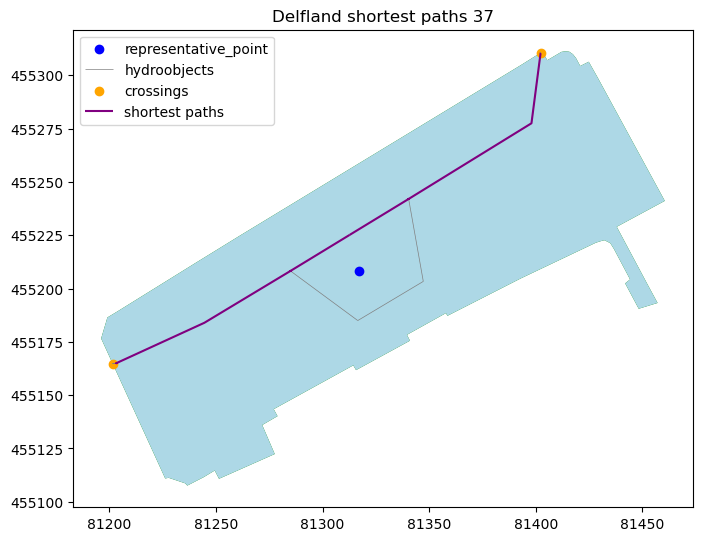

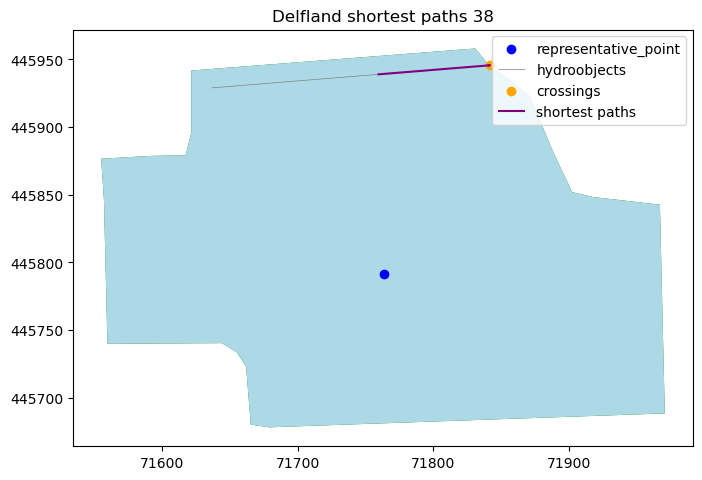

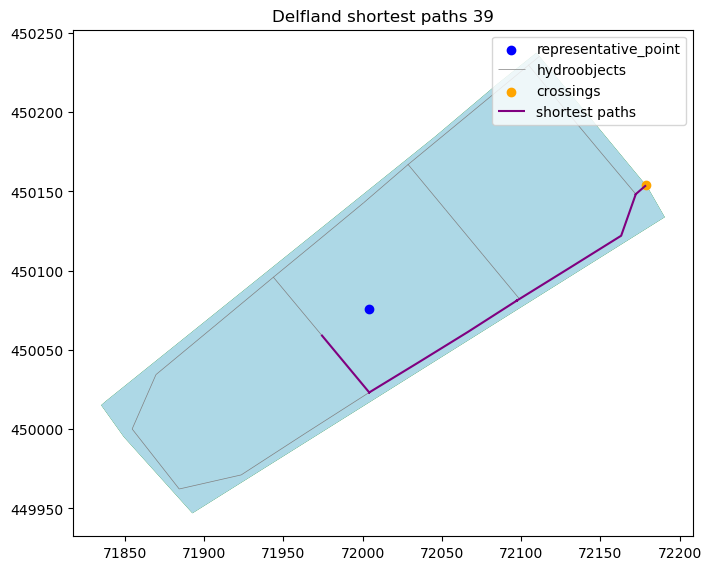

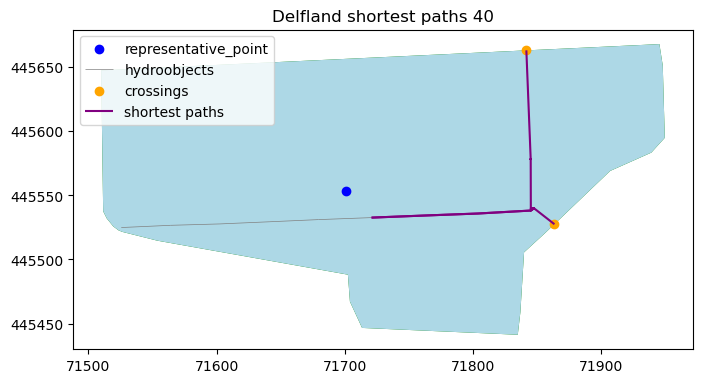

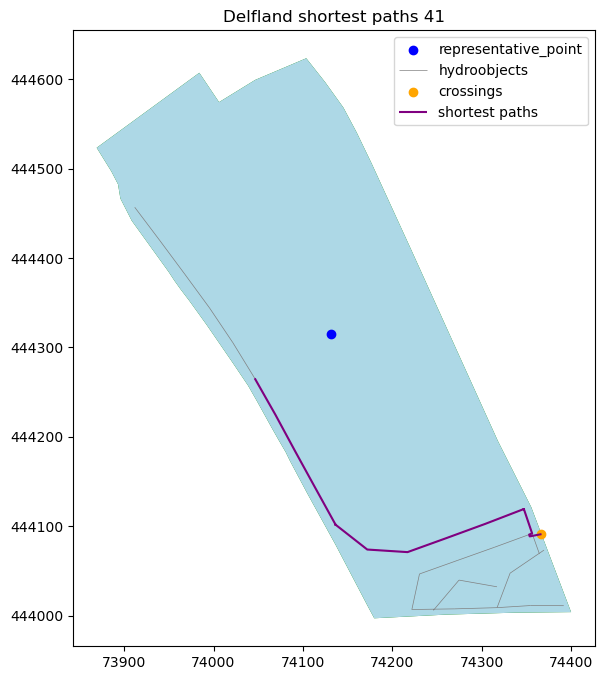

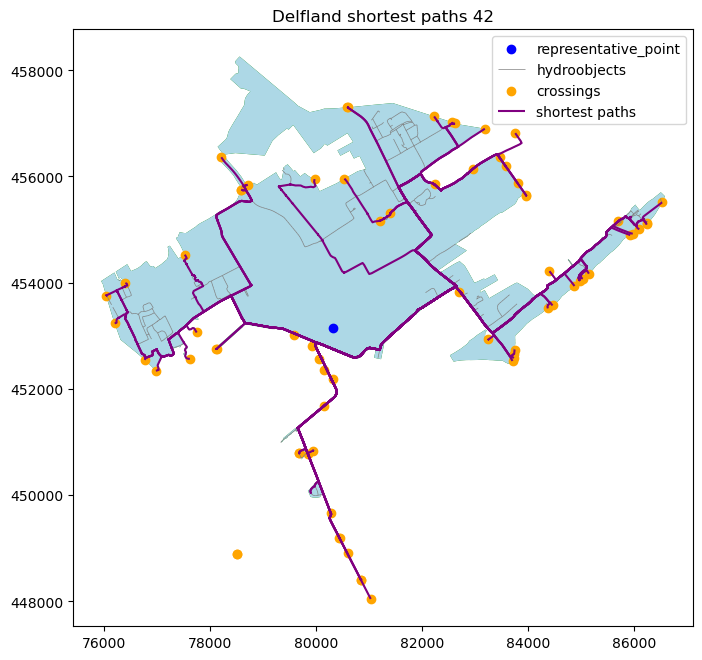

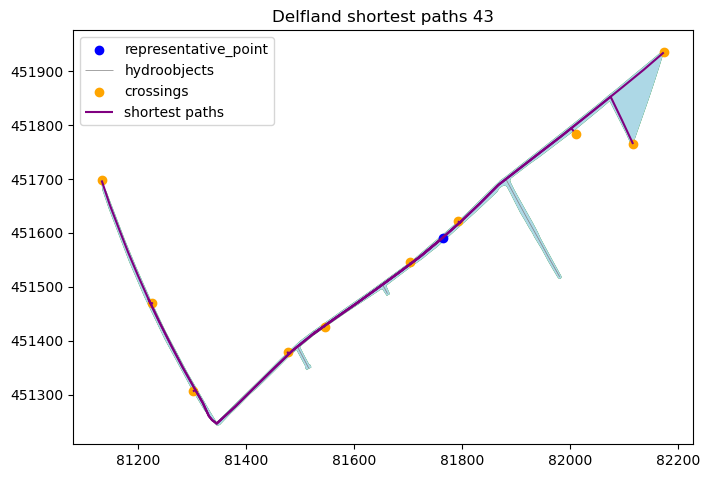

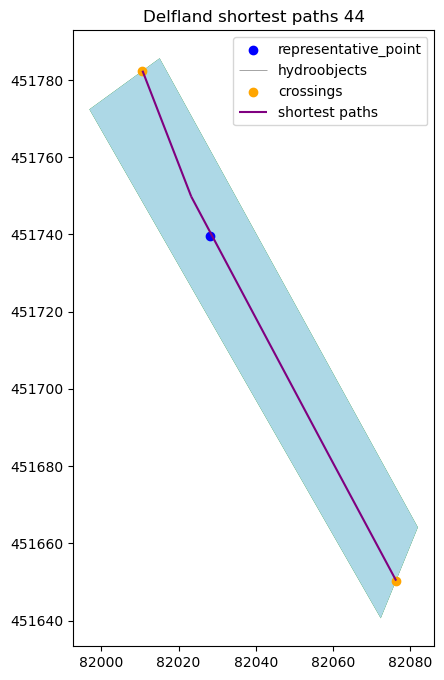

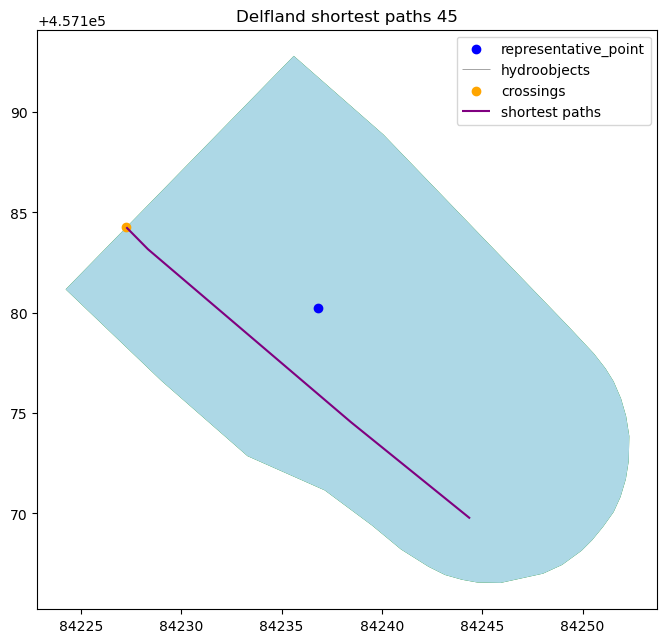

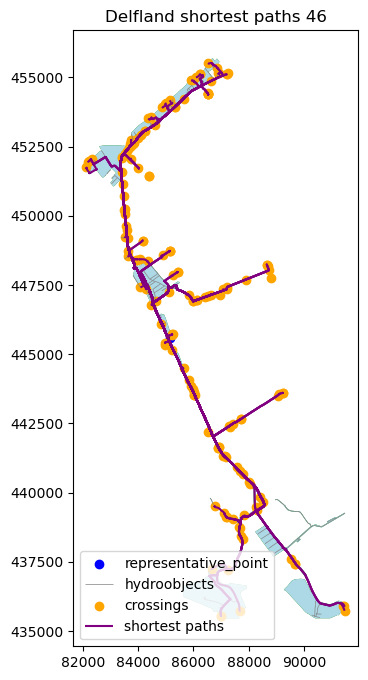

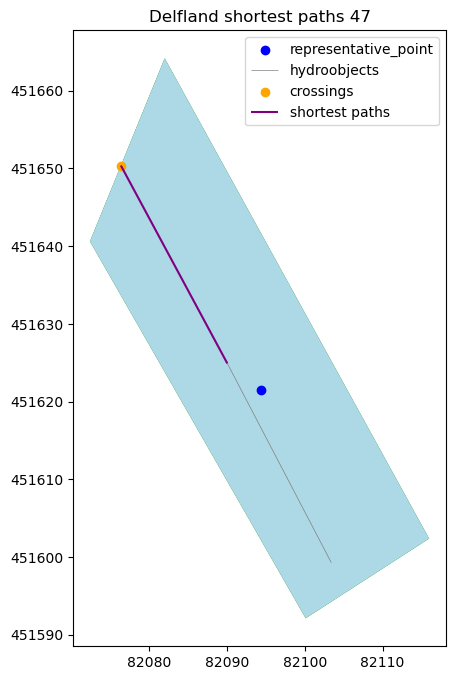

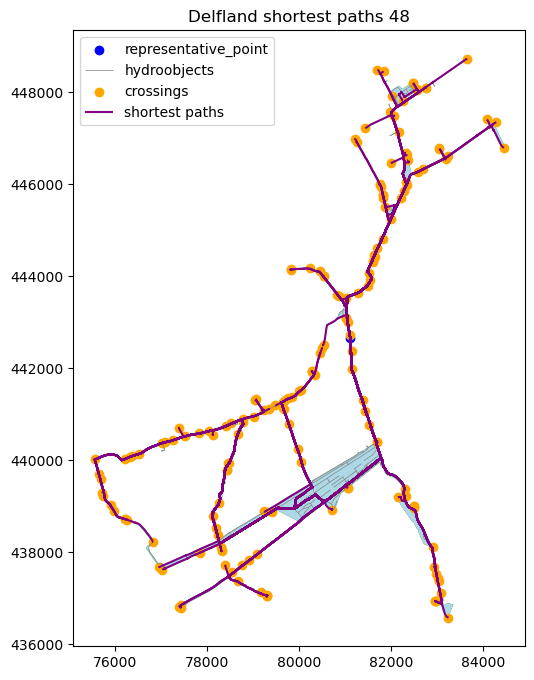

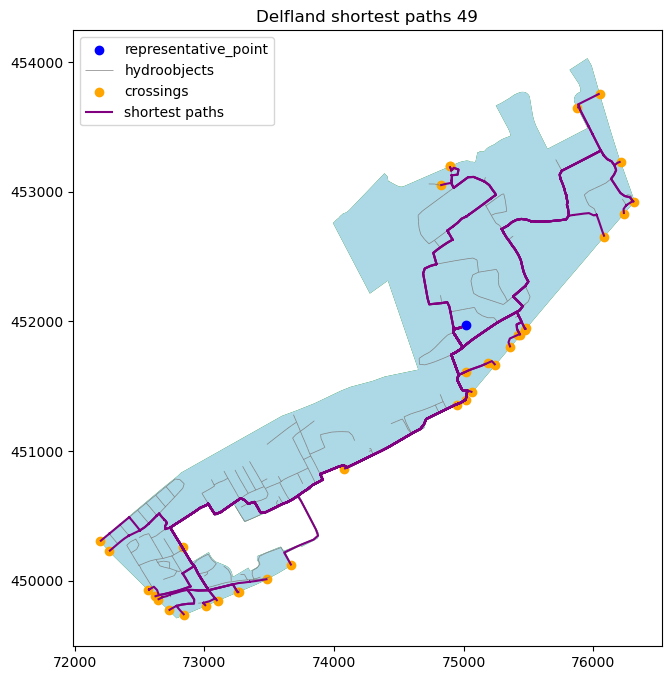

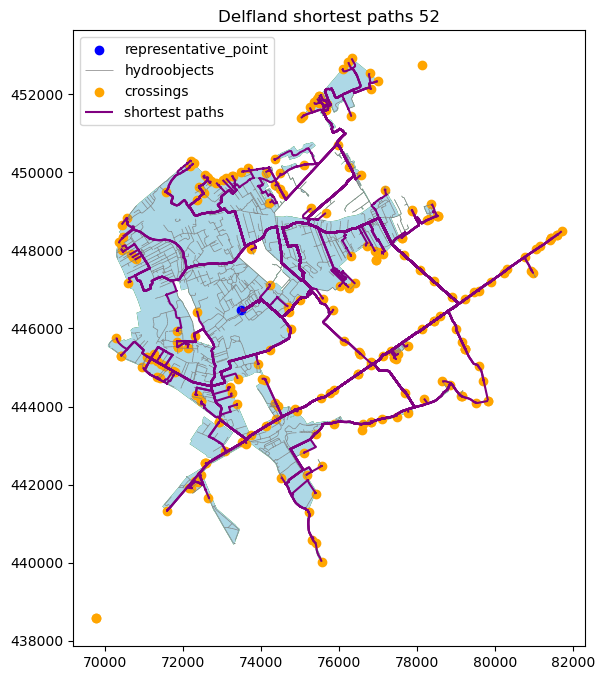

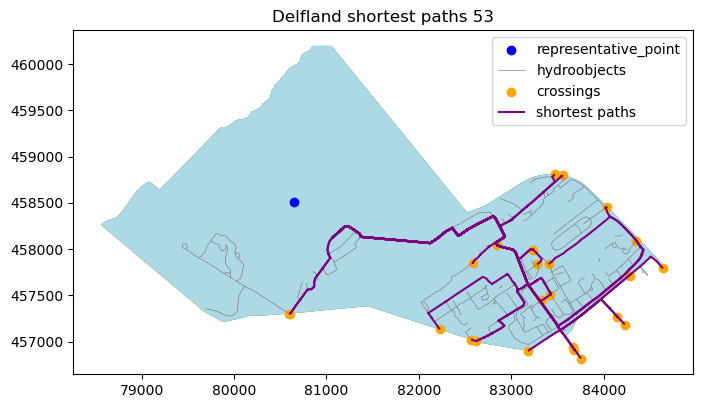

In [20]:
gdf_crossings_out = []
gdf_rhws = gdf_rhws.reset_index(drop=True)

# Loop RHWS polygons
gdf_crossings_out = []


for index, rhws in tqdm.tqdm(gdf_rhws.iterrows(), total=len(gdf_rhws), colour='blue'):

    try:
        print(index)
        
        ### Select Crossings/Hydroobjects ###
        print("Select Crossings/Hydroobjects")
        
        # Single RHWS row as GeoDataFrame
        gdf_rhws_single = gpd.GeoDataFrame(rhws.to_frame().T, geometry="geometry", crs=gdf_rhws.crs)
        
        # Select for each boezem polygon the relevant crossings
        globalid_value = gdf_rhws_single.globalid.iloc[0]
        gdf_cross_single = gdf_cross[(gdf_cross.peilgebied_from == globalid_value) | (gdf_cross.peilgebied_to == globalid_value)].copy()
        print("Clip Crossings/Hydroobjects")
        # Select hydroobjects in RHWS polygons
        gdf_object = gpd.clip(DATA["hydroobject"], gdf_rhws_single)
        gdf_object = gdf_object.reset_index(drop=True)
        
        # Explode linestrings
        gdf_object = gdf_object.explode(index_parts=False).reset_index(drop=True)
        gdf_object = gdf_object[~gdf_object.is_empty].copy()
        gdf_object = gdf_object[gdf_object.length > 1e-7].copy()
        print("Split Hydroobjects at Intersect")
        # Split lines at intersection
        gdf_object = split_lines_at_intersections(gdf_object)
        
        print("Connect Hydroobjects within distance")
        # Explode the linestrings into smaller segments
        distance_interval = 50  # The distance interval you want to segment the lines at
        gdf_object = explode_linestrings(gdf_object, distance_interval)
        
        # Make sure that hydroobjects are connected
        gdf_object = connect_linestrings_within_distance(gdf_object)
        
        # Explode linestrings
        gdf_object = gdf_object.explode(index_parts=False).reset_index(drop=True)
        gdf_object = gdf_object[~gdf_object.is_empty].copy()
        gdf_object = gdf_object[gdf_object.length > 1e-7].copy()
        
        
        ### Create NetworkX nodes ###
        print("Create NetworkX")
        # Use start and end points from hydroobjects in networkx as nodes
        nodes_gdf = gdf_object.copy()
        nodes_gdf["geometry"] = nodes_gdf.geometry.boundary
        nodes_gdf = nodes_gdf.explode(index_parts=True)
        
        # Use the unique points as nodes in networkx
        nodes_gdf.insert(0, "node_id", -1)
        node_id = 1
        for geom, group in nodes_gdf.groupby("geometry"):
            nodes_gdf.loc[group.index, "node_id"] = node_id
            node_id += 1
            
        ### Select startpoints & endpoints RHWS network ###
        # Find the closest starting points from the crossings.
        # Keep only points which are (almost) equal to the crossings.
        startpoints, distances = nodes_gdf.sindex.nearest(gdf_cross_single.geometry, return_all=False, return_distance=True)
        startpoints = nodes_gdf.node_id.iloc[startpoints[1,:]].values
        
        gdf_cross_single["node_id"] = startpoints
        gdf_cross_single["node_id_distance"] = distances
        
        # find the node_id closest to the RHWS representative point (end point)
        # Exclude the points which are already used as starting points
        df_endpoint = nodes_gdf[~nodes_gdf.node_id.isin(gdf_cross_single.node_id)].copy()
        endpoint, distance = df_endpoint.sindex.nearest(rhws.representative_point, return_all=False, return_distance=True)
        
        endpoint = df_endpoint.node_id.iat[endpoint[1,0]]
        gdf_rhws_single["node_id"] = endpoint
        gdf_rhws_single["node_id_distance"] = distance


        
        ### Create networkx graph ###
        graph = nx.Graph()
        
        # add nodes in boezem
        for node_id, group in nodes_gdf.groupby("node_id"):
            graph.add_node(node_id, geometry=group.geometry.iat[0])
        
        # add edges
        line_lookup = gdf_object.geometry
        for idx0, group in nodes_gdf.groupby(level=0):
            node_from, node_to = group.node_id
            line_geom = gdf_object.geometry.at[idx0]
            graph.add_edge(node_from, node_to, length=line_geom.length, geometry=line_geom)
        
        ### Find distruptions Graph ###
        # The graph often consists of multiple smaller graphs due to edges not properly connecting with nodes
        # Get lists of compnents (sub-graph)  
        print("Find distruptions in Graph")
        components = list(nx.connected_components(graph))
        largest_component = max(components, key=len) 
        smaller_components = [comp for comp in components if comp != largest_component] # not used anymore
        print(len(smaller_components), end="\r")
        
        while True:
            
            components = list(nx.connected_components(graph))
            largest_component = max(components, key=len)
            smaller_components = [comp for comp in components if comp != largest_component]
            
            if not smaller_components:  # If there are no smaller components left, break the loop
                break
                
            print(len(smaller_components), end='\r')
            # Update node geometries and largest_gdf for each iteration
            node_geometries = {node: graph.nodes[node]['geometry'] for node in graph.nodes()}
            largest_gdf = component_to_gdf(largest_component, node_geometries)
            smaller_gdfs = [component_to_gdf(comp, node_geometries) for comp in smaller_components]
            
            # Find the closest smaller_gdf to the largest_gdf
            closest_index, (node_in_largest, node_in_smaller) = find_closest_component_pair(largest_gdf, smaller_gdfs)
            
            # Connect the closest nodes
            connect_components(graph, node_in_largest, node_in_smaller, node_geometries)
           
        # calculate shortest_path networkx
        gdf_cross_single["shortest_path"] = shapely.geometry.GeometryCollection()
        not_connected = []
        
        components = list(nx.connected_components(graph))
        largest_component = max(components, key=len) 
        smaller_components = [comp for comp in components if comp != largest_component]
        node_geometries = {node: graph.nodes[node]['geometry'] for node in graph.nodes()}
        
        for startpoint in startpoints:
            try:
                shortest_path = nx.shortest_path(graph, source=startpoint, target=endpoint, weight="length", method="dijkstra")
                edges = []
                for i in range(0, len(shortest_path)-1):
                    edges.append(graph.get_edge_data(shortest_path[i], shortest_path[i+1])["geometry"])
                gdf_cross_single.loc[gdf_cross_single.node_id == startpoint, "shortest_path"] = shapely.ops.linemerge(edges)
        
            except nx.NetworkXNoPath as e:
                print(e)
                not_connected.append(startpoint)
                
        if not_connected:
            print("not connected")
            # Force connection
            # Convert the largest connected component to a GeoDataFrame for spatial operations
            largest_component_gdf = gpd.GeoDataFrame(geometry=[node_geometries[node] for node in largest_component], crs=gdf_rhws.crs)
            largest_component_gdf['node_id'] = list(largest_component)
        
            # Iterate over each not_connected node
            for nc_node in not_connected:
                nc_node_geom = node_geometries[nc_node]
        
                # Calculate the distance to all nodes in the largest component
                distances = largest_component_gdf.geometry.distance(nc_node_geom)
        
                # Find the closest node in the largest component
                closest_node_id = largest_component_gdf.iloc[distances.idxmin()].node_id
        
                # Add edge between not_connected node and closest node in the largest component
                # Note: You might want to calculate the LineString geometry connecting these nodes based on your specific requirements
                graph.add_edge(nc_node, closest_node_id, geometry=LineString([node_geometries[nc_node], node_geometries[closest_node_id]]))
        
            for startpoint in startpoints:
                try:
                    shortest_path = nx.shortest_path(graph, source=startpoint, target=endpoint, weight="length", method="dijkstra")
                    edges = []
                    for i in range(0, len(shortest_path)-1):
                        edges.append(graph.get_edge_data(shortest_path[i], shortest_path[i+1])["geometry"])
                    gdf_cross_single.loc[gdf_cross_single.node_id == startpoint, "shortest_path"] = shapely.ops.linemerge(edges)
        
                except nx.NetworkXNoPath as e:
                    print(e)
                    not_connected.append(startpoint)
        
        ### Append output ###
        gdf_crossings_out.append(gdf_cross_single)
        
        
        ### Plot graph ###
        print("Plotting Output")
        fig, ax = plt.subplots(figsize=(8,8))
        plt_paths = gpd.GeoDataFrame(gdf_cross_single, geometry="shortest_path", crs=gdf_cross_single.crs)
        plt_rep = gpd.GeoDataFrame(gdf_rhws_single, geometry="representative_point", crs=gdf_rhws_single.crs)
        plt_rhws = gpd.GeoDataFrame(gdf_rhws_single, geometry="geometry", crs=gdf_rhws_single.crs)
        ax.set_title(f"{waterschap} shortest paths {index}")
        plt_rhws.plot(ax=ax,color='green')
        gdf_rhws_single.plot(ax=ax, color="lightblue")
        plt_rep.plot(ax=ax, color="blue", label="representative_point")
        gdf_object.plot(ax=ax, color="gray", linewidth=0.5, label="hydroobjects")
        gdf_cross_single.plot(ax=ax, color="orange", label="crossings")
        plt_paths.plot(ax=ax, color="purple", label="shortest paths")
        ax.legend()
        plt.savefig(f"./shortest_path/Figures/shortest_path_{waterschap}_RHWS_{index}_new", dpi=300)
        
        # Save results
        print("Writing Output")
        objects = {}
        objects['hydroobjects'] = gpd.GeoDataFrame(gdf_object, geometry="geometry", crs=gdf_cross_single.crs)    
        shortest_path = gdf_cross_single.drop(columns=['geometry'])
        shortest_path = shortest_path.rename(columns={'shortest_path':'geometry'})                                       
        shortest_path = gpd.GeoDataFrame(shortest_path, geometry="geometry", crs=gdf_cross_single.crs)
        shortest_path["geometry"] = shortest_path.apply(lambda r: shapely.simplify(r.geometry, tolerance=1, preserve_topology=True), axis=1)
        
        objects['shortest_path'] = shortest_path
        objects['rhws'] = gpd.GeoDataFrame(gdf_rhws_single, geometry="geometry", crs=gdf_rhws_single.crs).drop(columns=['representative_point'])
        objects['crossings'] = gdf_cross_single.drop(columns=['shortest_path'])
        objects['representative_point'] = gpd.GeoDataFrame(gdf_rhws_single, geometry="representative_point", crs=gdf_rhws_single.crs).drop(columns=['geometry'])
        objects['nodes'] = gpd.GeoDataFrame(nodes_gdf, geometry="geometry", crs=gdf_cross_single.crs)
        
        for key, value in objects.items():
            # For each GeoDataFrame, save it to a layer in the GeoPackage
            value.to_file(f'./shortest_path/Geopackages/{waterschap}_unconnected_{index}.gpkg', layer=key, driver='GPKG')
    except Exception as e:
        print(e)
        
# Write final output
gdf_out = gpd.GeoDataFrame(pd.concat(gdf_crossings_out))
gdf_out['shortest_path'] = gdf_out['shortest_path'].apply(lambda geom: dumps(geom) if geom is not None else None)
gdf_out.to_file(f"/DATAFOLDER/projects/4750_30/Data_shortest_path/{waterschap}/{waterschap}_shortest_path.gpkg", driver='GPKG')